In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

import scipy.sparse as sparse
import seaborn as sns
from Bio.SeqFeature import FeatureLocation
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio.Seq import Seq

from math import log,exp,inf

import logomaker as lm
import Bio.motifs as motifs
import re

sys.path.append('../../bitome2')
sys.path.append('../')
sys.path.append('../../bitome2_workflows/DnaFeaturesViewer-master/')


from bitome.core import Bitome
from feature_functions import *

In [2]:
# K12 MG1655 Genebank

K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]


In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

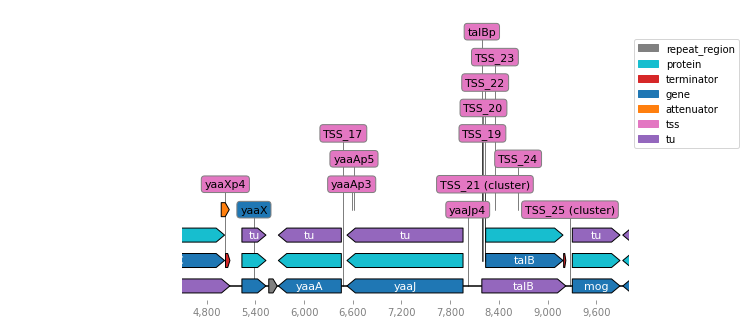

In [5]:
mg1655.view_region(4500, 10000)

In [6]:
# import non-coding snp

noncoding_snp_df = pd.read_csv('noncoding_snp_df.csv')
noncoding_snp_df

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
0,136,42C,2,163,1,1,1.0,NC_000913,703652,SNP,intergenic (‑41/‑292),A→G,nagB/nagE,False,Escherichia coli
1,155,42C,2,163,1,1,1.0,NC_000913,3346530,SNP,intergenic (+70/‑48),C→A,hpf/ptsN,False,Escherichia coli
2,110,42C,3,120,1,1,1.0,NC_000913,1755639,SNP,intergenic (‑498/‑59),G→A,ydhZ/pykF,False,Escherichia coli
3,115,42C,3,120,1,1,1.0,NC_000913,2731312,SNP,intergenic (‑155/+288),G→A,rrsG/clpB,False,Escherichia coli
4,77,42C,4,161,1,1,1.0,NC_000913,1115627,SNP,intergenic (‑137/+35),C→T,mdtG/lpxL,False,Escherichia coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,22,tpiKO,6,8,1,1,1.0,NC_000913,3088193,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli
6453,4,tpiKO,7,28,1,1,1.0,NC_000913,1420279,SNP,intergenic (‑38/‑86),C→A,racR/ydaS,False,Escherichia coli
6454,22,tpiKO,7,28,1,1,1.0,NC_000913,3088193,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli
6455,90,tpiKO,10,28,1,1,1.0,NC_000913,3088191,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli


### EEP is a combination of 8+ experiments each with 4 or 5 ALEs
### whereas SSW, 42C, and GLU are all single experiments with a total of 8-10 ALEs

In [7]:
# select glucose evlution

noncoding_snp_GLU = noncoding_snp_df.loc[noncoding_snp_df['exp'] 
                                          == 'BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-KH2PO43-MgSO4024-O2']

# select 42C evolution

noncoding_snp_42C = noncoding_snp_df.loc[noncoding_snp_df['exp'] == '42C']

# select substrate switching

noncoding_snp_SSW = noncoding_snp_df[noncoding_snp_df['exp'].str.contains('SSW')]

# select respiratory quinone

EEP_list = ['EEP-menF','EEP-ubic','EEP-menFubiC','EEP-menFentC','EEP-menFubiCentC']
noncoding_snp_EEP = noncoding_snp_df[(noncoding_snp_df.exp == 'EEPmenF')
                                      | (noncoding_snp_df.exp == 'EEPubic')
                                      | (noncoding_snp_df.exp == 'EEPmenFubiC')
                                      | (noncoding_snp_df.exp == 'EEPmenFentC')
                                      | (noncoding_snp_df.exp == 'EEPmenFubiCentC')]

noncoding_snp_SSW

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
5676,3,SSW_AC,1,56,1,1,1.00,NC_000913,3222566,SNP,intergenic (+117/‑67),C→A,ebgR/ebgA,False,Escherichia coli
5677,10,SSW_AC,2,57,1,1,1.00,NC_000913,1907447,SNP,intergenic (‑12/+1),C→A,cspC/yobF,False,Escherichia coli
5678,69,SSW_GLU_AC,8,91,1,1,1.00,NC_000913,3815810,SNP,intergenic (‑42/+24),G→T,pyrE/rph,False,Escherichia coli
5679,10,SSW_GLU_AC,8,91,7,1,1.00,NC_000913,4073641,SNP,intergenic (‑70/‑98),C→A,yihU/yihV,False,Escherichia coli
5680,15,SSW_GLU_AC,9,92,6,1,1.00,NC_000913,781757,SNP,intergenic (+105/‑328),G→T,lysQ/nadA,False,Escherichia coli
5681,11,SSW_GLU_GLY,4,165,0,1,0.23,NC_000913,3950469,SNP,intergenic (+49/‑38),T→G,ilvL/ilvX,False,Escherichia coli
5682,220,SSW_GLU_XYL,1,163,6,1,1.00,NC_000913,44145,SNP,intergenic (+16/‑35),C→T,fixB/fixC,False,Escherichia coli
5683,23,SSW_GLU_XYL,1,163,1,1,1.00,NC_000913,191723,SNP,intergenic (+15/‑132),C→T,tsf/pyrH,False,Escherichia coli
5684,64,SSW_GLU_XYL,1,163,4,1,1.00,NC_000913,222672,SNP,intergenic (‑27/‑161),A→G,metN/gmhB,False,Escherichia coli
5685,221,SSW_GLU_XYL,1,163,6,1,1.00,NC_000913,311982,SNP,intergenic (‑646/‑130),G→A,ecpR/ykgL,False,Escherichia coli


In [8]:
# convergent mutation in ALE = GLU experiments

noncoding_snp_GLU[noncoding_snp_GLU.duplicated(subset = 'Gene', keep = False)].sort_values(by = 'Gene')

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
75,731,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,4,403,0,1,0.36,NC_000913,2151689,SNP,intergenic (+43/+22),G→T,yegJ/yegK,False,Escherichia coli
78,731,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,6,406,0,1,0.50,NC_000913,2151689,SNP,intergenic (+43/+22),G→T,yegJ/yegK,False,Escherichia coli
115,550,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,236,1,1,1.00,NC_000913,2278251,SNP,intergenic (‑14/+319),A→C,yejG/bcr,False,Escherichia coli
116,361,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,422,51,1,1.00,NC_000913,2278486,SNP,intergenic (‑249/+84),T→G,yejG/bcr,False,Escherichia coli
141,290,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,236,1,1,1.00,NC_000913,4046716,SNP,intergenic (‑114/‑250),A→C,yihG/polA,False,Escherichia coli
142,291,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,422,52,1,1.00,NC_000913,4046941,SNP,intergenic (‑339/‑25),A→C,yihG/polA,False,Escherichia coli


In [9]:
# convergent mutation in ALE = 42C experiments

noncoding_snp_42C[noncoding_snp_42C.duplicated(subset = 'Gene', keep = False)].sort_values(by = 'Gene')

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
10,29,42C,6,164,1,1,1.0,NC_000913,1292944,SNP,intergenic (‑22/‑583),T→C,hns/tdk,False,Escherichia coli
21,29,42C,8,164,1,1,1.0,NC_000913,1292944,SNP,intergenic (‑22/‑583),T→C,hns/tdk,False,Escherichia coli
16,53,42C,6,164,1,1,1.0,NC_000913,3853909,SNP,intergenic (+267/‑13),A→G,tisB/emrD,False,Escherichia coli
27,53,42C,8,164,1,1,1.0,NC_000913,3853909,SNP,intergenic (+267/‑13),A→G,tisB/emrD,False,Escherichia coli
7,24,42C,6,164,1,1,1.0,NC_000913,720946,SNP,intergenic (+106/+110),C→T,ybfK/kdpE,False,Escherichia coli
19,24,42C,8,164,1,1,1.0,NC_000913,720946,SNP,intergenic (+106/+110),C→T,ybfK/kdpE,False,Escherichia coli
5,80,42C,4,161,1,1,1.0,NC_000913,2810760,SNP,intergenic (+81/‑10),T→C,ygaH/mprA,False,Escherichia coli
6,80,42C,5,125,1,1,1.0,NC_000913,2810760,SNP,intergenic (+81/‑10),T→C,ygaH/mprA,False,Escherichia coli
13,10,42C,6,164,1,1,1.0,NC_000913,2810756,SNP,intergenic (+77/‑14),G→A,ygaH/mprA,False,Escherichia coli
24,10,42C,8,164,1,1,1.0,NC_000913,2810756,SNP,intergenic (+77/‑14),G→A,ygaH/mprA,False,Escherichia coli


In [10]:
# convergent mutation in ALE = SSW experiments

noncoding_snp_SSW[noncoding_snp_SSW.duplicated(subset = 'Gene', keep = False)].sort_values(by = 'Gene')

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
5693,95,SSW_GLU_XYL,1,163,4,1,1.00,NC_000913,4168472,SNP,intergenic (+25/‑169),G→A,gltT/rrlB,False,Escherichia coli
5694,97,SSW_GLU_XYL,1,163,4,1,1.00,NC_000913,4168571,SNP,intergenic (+124/‑70),G→A,gltT/rrlB,False,Escherichia coli
5695,98,SSW_GLU_XYL,1,163,4,1,1.00,NC_000913,4168618,SNP,intergenic (+171/‑23),A→T,gltT/rrlB,False,Escherichia coli
5681,11,SSW_GLU_GLY,4,165,0,1,0.23,NC_000913,3950469,SNP,intergenic (+49/‑38),T→G,ilvL/ilvX,False,Escherichia coli
5700,132,SSW_GLU_XYL,3,164,4,1,1.00,NC_000913,3950469,SNP,intergenic (+49/‑38),T→G,ilvL/ilvX,False,Escherichia coli
5678,69,SSW_GLU_AC,8,91,1,1,1.00,NC_000913,3815810,SNP,intergenic (‑42/+24),G→T,pyrE/rph,False,Escherichia coli
5699,210,SSW_GLU_XYL,3,164,2,1,1.00,NC_000913,3815811,SNP,intergenic (‑43/+23),C→T,pyrE/rph,False,Escherichia coli
5702,12,SSW_GLU_XYL_GLY_AC,10,105,0,1,1.00,NC_000913,3815824,SNP,intergenic (‑56/+10),G→A,pyrE/rph,False,Escherichia coli


In [11]:
# convergent mutation in ALE = EEP experiments

noncoding_snp_EEP[noncoding_snp_EEP.duplicated(subset = 'Gene', keep = False)].sort_values(by = 'Gene')

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
4357,6930,EEPmenFubiC,9,14,0,1,0.20,NC_000913,3407293,SNP,intergenic (+29/‑80),T→A,accC/yhdT,False,Escherichia coli
4355,9820,EEPmenFubiC,9,14,0,1,0.21,NC_000913,3407291,SNP,intergenic (+27/‑82),T→A,accC/yhdT,False,Escherichia coli
4356,9821,EEPmenFubiC,9,14,0,1,0.20,NC_000913,3407292,SNP,intergenic (+28/‑81),T→A,accC/yhdT,False,Escherichia coli
4530,79,EEPmenFubiCentC,38,28,0,1,0.21,NC_000913,1703252,SNP,intergenic (+18/+16),A→T,add/ydgJ,False,Escherichia coli
4529,78,EEPmenFubiCentC,38,28,0,1,0.21,NC_000913,1703251,SNP,intergenic (+17/+17),A→T,add/ydgJ,False,Escherichia coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4369,2945,EEPmenFubiC,9,14,0,1,0.21,NC_000913,4297197,SNP,intergenic (‑71/+23),A→C,yjcO/fdhF,False,Escherichia coli
4293,38,EEPmenF,8,45,0,2,0.29,NC_000913,2229175,SNP,intergenic (+112/+261),A→C,yohP/dusC,False,Escherichia coli
4333,3082,EEPmenFubiC,9,14,0,1,0.20,NC_000913,2229175,SNP,intergenic (+112/+261),A→C,yohP/dusC,False,Escherichia coli
4345,9759,EEPmenFubiC,9,14,0,1,0.25,NC_000913,3156589,SNP,intergenic (+73/‑32),T→G,yqhD/dkgA,False,Escherichia coli


In [12]:
# number of type of convergent mutations in EEP experiment

EEP_duplicates = noncoding_snp_EEP[noncoding_snp_EEP.duplicated(subset = 'Gene', keep = False)]
len(EEP_duplicates.drop_duplicates(subset = 'Gene'))                                                                                    

64

In [13]:
tfbs_table = mg1655.tfbs_table
tfbs_table

,left,right,mode,final_state,tf,strand
locus_tag,,,,,,
ECK120011181,612650,612668,repressor,Fur-Fe<SUP>2+</SUP>,Fur,NaN
ECK120011181,612650,612668,repressor,Fur-Fe<SUP>2+</SUP>,Fur,NaN
ECK120011184,4516744,4516762,repressor,Fur-Fe<SUP>2+</SUP>,Fur,NaN
ECK120011188,1619005,1619019,activator,Fis,Fis,NaN
ECK120011197,3305958,3305975,activator,TyrR-tyrosine,TyrR,NaN
...,...,...,...,...,...,...
ECK125285759,2089156,2089173,NaN,NaN,NaN,NaN
ECK125285760,890761,890777,activator,OxyR,OxyR,NaN
ECK125285761,4148594,4148611,NaN,NaN,NaN,NaN


In [14]:
tfbs_snp_dfs = []

for tfbs_row in tfbs_table.itertuples():
    
    left = tfbs_row.left
    right = tfbs_row.right
    tf = tfbs_row.tf

# look for SNPs within left & right; can't do blah < x < blah2 in Pandas syntax unfortunately
    nc_snps_in_tfbs = noncoding_snp_df[
        (left <= noncoding_snp_df['Position']) & 
        (right >= noncoding_snp_df['Position'])
    ]
    
# if this wasn't empty, cool! we have a promoter mutation! accumulate these into a new dataframe
    if not nc_snps_in_tfbs.empty:
        nc_snps_in_tfbs = nc_snps_in_tfbs.copy()
    
    # add left & right information. add tf information for the name of the TF that has a mutated binding site
        nc_snps_in_tfbs['left'] = left
        nc_snps_in_tfbs['right'] = right
        nc_snps_in_tfbs['tf'] = tf
        tfbs_snp_dfs.append(nc_snps_in_tfbs)
        
tfbs_snp_df = pd.concat(tfbs_snp_dfs)
tfbs_snp_df

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism,left,right,tf
6019,109,TOL_hexamethylenediamine,4,50,3,1,1.00,NC_000913,940856,SNP,intergenic (+136/‑103),A→G,serS/dmsA,False,Escherichia coli,940850,940862,IHF
3573,323,CCK_pgi,3,9,0,1,0.20,NC_000913,816792,SNP,intergenic (‑145/‑252),C→A,ybhK/moaA,False,Escherichia coli,816781,816794,FNR
5973,54,TOL_adipic_acid,5,50,2,1,1.00,NC_000913,1842229,SNP,intergenic (‑94/‑142),T→G,ynjH/gdhA,False,Escherichia coli,1842220,1842234,Nac
5291,27,HOT,16,48,0,1,0.21,NC_000913,3059703,SNP,intergenic (‑2/‑50),A→T,yqfE/argP,False,Escherichia coli,3059694,3059712,PhoB
5292,28,HOT,16,48,0,1,0.21,NC_000913,3059704,SNP,intergenic (‑3/‑49),A→T,yqfE/argP,False,Escherichia coli,3059694,3059712,PhoB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949,182,TOL_adipic_acid,1,50,1,1,1.00,NC_000913,4294366,SNP,intergenic (+227/‑115),A→T,nrfG/gltP,False,Escherichia coli,4294365,4294382,NaN
5590,196,ILT_mg1655,4,84,10,1,1.00,NC_000913,4222743,SNP,intergenic (‑256/+61),C→T,arpA/iclR,False,Escherichia coli,4222735,4222750,NaN
3667,153,ECNR2.1,10,1,1,1,1.00,NC_000913,638619,SNP,intergenic (‑46/‑326),A→G,dsbG/ahpC,False,Escherichia coli,638611,638630,NaN
5966,277,TOL_adipic_acid,5,50,1,1,1.00,NC_000913,1404625,SNP,intergenic (‑60/‑116),A→C,abgA/abgR,False,Escherichia coli,1404611,1404628,NaN


In [15]:
# add information: the number of SNPs per each unique tf

tfbs_snp_df['snp_per_tf'] = tfbs_snp_df.groupby('tf')['tf'].transform('count')
tfbs_snp_df

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism,left,right,tf,snp_per_tf
6019,109,TOL_hexamethylenediamine,4,50,3,1,1.00,NC_000913,940856,SNP,intergenic (+136/‑103),A→G,serS/dmsA,False,Escherichia coli,940850,940862,IHF,24.0
3573,323,CCK_pgi,3,9,0,1,0.20,NC_000913,816792,SNP,intergenic (‑145/‑252),C→A,ybhK/moaA,False,Escherichia coli,816781,816794,FNR,3.0
5973,54,TOL_adipic_acid,5,50,2,1,1.00,NC_000913,1842229,SNP,intergenic (‑94/‑142),T→G,ynjH/gdhA,False,Escherichia coli,1842220,1842234,Nac,1.0
5291,27,HOT,16,48,0,1,0.21,NC_000913,3059703,SNP,intergenic (‑2/‑50),A→T,yqfE/argP,False,Escherichia coli,3059694,3059712,PhoB,14.0
5292,28,HOT,16,48,0,1,0.21,NC_000913,3059704,SNP,intergenic (‑3/‑49),A→T,yqfE/argP,False,Escherichia coli,3059694,3059712,PhoB,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5949,182,TOL_adipic_acid,1,50,1,1,1.00,NC_000913,4294366,SNP,intergenic (+227/‑115),A→T,nrfG/gltP,False,Escherichia coli,4294365,4294382,NaN,NaN
5590,196,ILT_mg1655,4,84,10,1,1.00,NC_000913,4222743,SNP,intergenic (‑256/+61),C→T,arpA/iclR,False,Escherichia coli,4222735,4222750,NaN,NaN
3667,153,ECNR2.1,10,1,1,1,1.00,NC_000913,638619,SNP,intergenic (‑46/‑326),A→G,dsbG/ahpC,False,Escherichia coli,638611,638630,NaN,NaN
5966,277,TOL_adipic_acid,5,50,1,1,1.00,NC_000913,1404625,SNP,intergenic (‑60/‑116),A→C,abgA/abgR,False,Escherichia coli,1404611,1404628,NaN,NaN


In [16]:
tfbs_snp_df.to_csv('tfbs_snp_df.csv')

### if certain TFBSs are mutated more than others

For each TF, the total number of SNPs that have occured within all of the binding sites

In [17]:
tfbs_table_count = tfbs_table.groupby('tf').size()

tfbs_snp_count = tfbs_snp_df.groupby('tf').size()

# relative_freq = (tfbs_snp_freq/tfbs_table_freq).dropna()
tfbs_table_count

tf
AcrR     7
Ada      4
AdiY     4
AgaR    11
AidB     1
        ..
YjjQ     7
YqhC     2
ZntR     1
ZraR     4
Zur      4
Length: 201, dtype: int64

## Histogram

where within the TFBS the SNPs are happening

above the plot: sequence logo/motif for the TFBS

In [45]:
mid = (tfbs_snp_crp.left+tfbs_snp_crp.right)/2
mid

148     4466270.5
4961    4419866.5
6023    2231776.5
6023    2231776.5
5622    4551460.5
5622    4551460.5
6077     576901.5
180     3772085.5
4642     127698.5
4678     127698.5
33      1103386.5
8       1103514.5
178     3409993.5
6034     990451.5
4717     366332.5
4717     366332.5
4717     366332.5
4438    1988049.5
4439    1988049.5
4440    1988049.5
4441    1988049.5
6153    3378858.0
3579    3532589.0
3586    3532589.0
dtype: float64

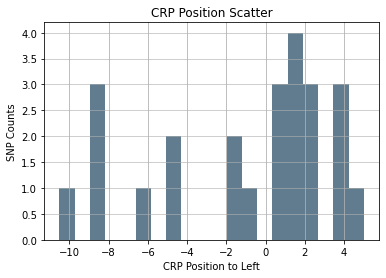

In [18]:
# tf = CRP

tfbs_snp_crp = tfbs_snp_df[tfbs_snp_df['tf'] == 'CRP']

tfbs_to_mid = ( tfbs_snp_crp.Position - (tfbs_snp_crp.left+tfbs_snp_crp.right)/2 )

tfbs_to_mid.plot.hist(grid=True, bins=20, rwidth=1,
                   color='#607c8e')
plt.title('CRP Position Scatter')
plt.xlabel('CRP Position to Left')
plt.ylabel('SNP Counts')
plt.grid(axis='y', alpha=0.75)

In [19]:
tfbs_snp_crp.head()

,Unnamed: 0,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism,left,right,tf,snp_per_tf
148,413,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,20,1,1,1.00,NC_000913,4466262,SNP,intergenic (‑82/+37),A→G,treB/treR,False,Escherichia coli,4466260,4466281,CRP,24.0
4961,167,GYD,22,44,0,1,0.21,NC_000913,4419860,SNP,intergenic (‑235/‑120),G→T,ulaG/ulaA,False,Escherichia coli,4419856,4419877,CRP,24.0
6023,165,TOL_hexamethylenediamine,4,50,2,1,1.00,NC_000913,2231778,SNP,intergenic (+64/‑66),G→T,yohK/cdd,False,Escherichia coli,2231766,2231787,CRP,24.0
6023,165,TOL_hexamethylenediamine,4,50,2,1,1.00,NC_000913,2231778,SNP,intergenic (+64/‑66),G→T,yohK/cdd,False,Escherichia coli,2231766,2231787,CRP,24.0
5622,64,LAC,7,57,0,1,1.00,NC_000913,4551452,SNP,intergenic (‑155/‑185),C→T,gntP/uxuA,False,Escherichia coli,4551450,4551471,CRP,24.0


In [20]:
mg1655.get_sequence(tfbs_snp_crp['left'].iloc[0], tfbs_snp_crp['right'].iloc[0], 1)

Seq('AAACGCAGCGAAGATCACAATT')

In [24]:
# last two have different length, so ignore

tfbs_snp_crp = tfbs_snp_df[tfbs_snp_df['tf'] == 'CRP']
tfbs_to_mid = ( tfbs_snp_crp.Position - (tfbs_snp_crp.left+tfbs_snp_crp.right)/2 )

crp_df = []
for i in range(len(tfbs_snp_crp)-3):
    crp_df.append(str(mg1655.get_sequence(tfbs_snp_crp['left'].iloc[i], tfbs_snp_crp['right'].iloc[i], 1)))

crp_list = np.array(crp_df)
crp_list

array(['AAACGCAGCGAAGATCACAATT', 'ATTTGCGGGTCGCGTCACATTT',
       'TAATGAGATTCAGATCACATAT', 'TAATGAGATTCAGATCACATAT',
       'TCTTGTGATGTGGTTAACCAAT', 'TCTTGTGATGTGGTTAACCAAT',
       'CAATGTGATTATTTCAAGATGT', 'TTTTGTGATGAACGTCACGTCA',
       'AATTGTTAACAATTTTGTAAAA', 'AATTGTTAACAATTTTGTAAAA',
       'AAGTGTTAAACATGTAACTAAA', 'AATGGTGATAACTTACTAATAA',
       'AAGTGCGAGCAAGCTCACAAAA', 'TTATTGAACCCCGATCACACCA',
       'AAATTGTTATCCGCTCACAATT', 'AAATTGTTATCCGCTCACAATT',
       'AAATTGTTATCCGCTCACAATT', 'TTATGTGATACAAATCACATAA',
       'TTATGTGATACAAATCACATAA', 'TTATGTGATACAAATCACATAA',
       'TTATGTGATACAAATCACATAA'], dtype='<U22')

In [25]:
pwm_db = rpwm('../data/motif_pwm_db.txt')
pwm_db['Crp']

[{'A': -0.6, 'C': -0.2, 'G': -0.9, 'T': 0.7},
 {'A': -0.8, 'C': -1.1, 'G': 1.0, 'T': -0.2},
 {'A': -1.0, 'C': -0.1, 'G': -1.0, 'T': 0.8},
 {'A': -0.8, 'C': -2.6, 'G': 1.3, 'T': -1.2},
 {'A': 0.9, 'C': -0.5, 'G': -0.9, 'T': -1.1},
 {'A': -0.2, 'C': -0.3, 'G': 0.0, 'T': 0.3},
 {'A': -0.2, 'C': 0.4, 'G': -0.1, 'T': -0.0},
 {'A': -0.5, 'C': 0.4, 'G': -0.1, 'T': 0.1},
 {'A': 0.4, 'C': -0.5, 'G': -0.1, 'T': -0.2},
 {'A': -0.5, 'C': 0.2, 'G': 0.4, 'T': -0.2},
 {'A': 0.5, 'C': -0.5, 'G': -0.0, 'T': -0.5},
 {'A': -1.9, 'C': -1.5, 'G': -1.3, 'T': 1.1},
 {'A': -1.0, 'C': 1.4, 'G': -1.6, 'T': -2.7},
 {'A': 1.1, 'C': -3.2, 'G': -1.0, 'T': -2.6},
 {'A': -1.4, 'C': 1.4, 'G': -1.8, 'T': -2.1},
 {'A': 1.0, 'C': -1.4, 'G': -0.4, 'T': -1.9},
 {'A': 0.2, 'C': -0.1, 'G': -1.0, 'T': 0.3},
 {'A': 0.1, 'C': -0.7, 'G': -5.6, 'T': 0.6},
 {'A': 0.1, 'C': -1.0, 'G': -0.9, 'T': 0.6},
 {'A': -0.3, 'C': -0.2, 'G': -1.6, 'T': 0.7}]

Text(0.5, 0, 'bp from TFBS mid (n=24.0)')

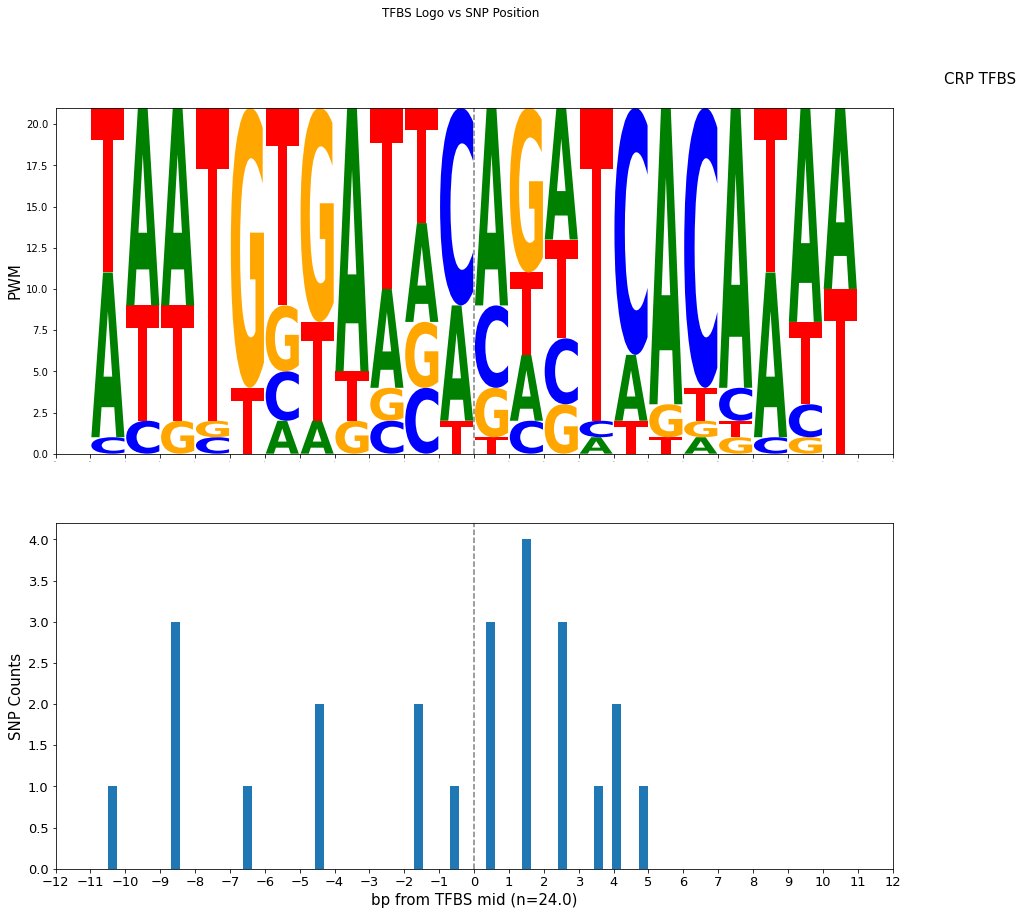

In [63]:
fig, axs = plt.subplots(2, 1, figsize=(15, 14) )
fig.suptitle('TFBS Logo vs SNP Position')

axs[1].hist(tfbs_to_mid, bins=60)
axs[1].set_ylabel('SNP Counts', fontsize=15)
axs[1].set_xlabel('')
axs[1].tick_params(axis='both', labelsize=13)
axs[1].set_xticks( np.arange(-12, 12.5, 1) )
axs[1].axvline(0, linestyle='--', color='gray')
ymin1, ymax1 = axs[1].get_ylim()

counts_mat = lm.alignment_to_matrix(sequences=crp_list, to_type='counts')
lm.Logo(counts_mat, ax = axs[0]);

axs[0].set_ylabel('PWM', fontsize=15)
axs[0].tick_params(axis='x', labelsize=1)
axs[0].set_xticks( np.arange(-1.5, 23, 1) )
axs[0].axvline(10.5, linestyle='--', color='gray')
ymin0, ymax0 = axs[0].get_ylim()

ax0_ymin, ax0_ymax = axs[0].get_ylim()
axs[0].text(25, ax0_ymax+(ax0_ymax-ax0_ymin)*0.07,'CRP TFBS', fontsize=15, ha='center')  
axs[-1].set_xlabel('bp from TFBS mid (n='+str(tfbs_snp_crp['snp_per_tf'].iloc[0])+')', fontsize=15)

# for ax in axs[0,1]:
#     plt.setp(ax.get_xticklabels(), visible=False )